In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import warnings
import os
import pdb
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import itertools
import pickle
import warnings
from scipy.optimize import fmin
from scipy.stats import norm
from PIL import Image
import random
import pdb
import matplotlib.colors as mcolors
import timm
import itertools

warnings.filterwarnings("ignore")

## need to define some functions here that we'll use.

In [100]:
def get_model(model_name):
    activations = []

    def get_activation(name):
        def hook(model, input, output):
            activations.append(output)
        return hook

    if model_name == 'resnet50':
        model = timm.create_model('resnet50', pretrained=True)
        layers_to_extract = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']  # Standard ResNet50 layers

    elif model_name == 'mobilenetv3_large_100':
        model = timm.create_model('mobilenetv3_large_100', pretrained=True)
        layers_to_extract = ['conv_stem', 'blocks.0', 'blocks.1', 'blocks.2', 'blocks.5', 'classifier']  # Correct block depth for MobileNetV3 (6 blocks)
    
    elif model_name == 'vgg16':
        model = timm.create_model('vgg16', pretrained=True)
        layers_to_extract = ['features.0', 'features.4', 'features.9', 'features.16', 'features.23', 'head.fc']  # VGG16 layers confirmed
    
    elif model_name == 'vgg19':
        model = timm.create_model('vgg19', pretrained=True)
        layers_to_extract = ['features.0', 'features.4', 'features.9', 'features.18', 'features.27', 'head.fc']  # VGG19 follows a similar structure to VGG16
    
    elif model_name == 'efficientnet_lite0':
        model = timm.create_model('efficientnet_lite0', pretrained=True)
        layers_to_extract = ['conv_stem', 'blocks.0', 'blocks.2', 'blocks.4', 'blocks.6', 'classifier']  # EfficientNet-Lite0 has 6 blocks (indexed correctly)
    
    elif model_name == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=True)
        layers_to_extract = ['conv_stem', 'blocks.0', 'blocks.2', 'blocks.4', 'blocks.6', 'classifier']  # Verified EfficientNet-B0's block count and depth (7 blocks total)
    
    elif model_name == 'resnet18':
        model = timm.create_model('resnet18', pretrained=True)
        layers_to_extract = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']  # ResNet18 confirmed as valid
    
    elif model_name == 'tf_efficientnet_b1_ns':
        model = timm.create_model('tf_efficientnet_b1_ns', pretrained=True)
        layers_to_extract = ['conv_stem', 'blocks.0', 'blocks.2', 'blocks.4', 'blocks.6', 'classifier']  # EfficientNet-B1 layers corrected (7 blocks)
    
    elif model_name == 'vit_base_patch8_224':
        model = timm.create_model('vit_base_patch8_224', pretrained=True)
        layers_to_extract = ['patch_embed.proj', 'blocks.1', 'blocks.4', 'blocks.7', 'blocks.11', 'head']  # ViT model confirmed (12 blocks)
    
    elif model_name == 'tf_efficientnetv2_s':
        model = timm.create_model('tf_efficientnetv2_s', pretrained=True)
        layers_to_extract = ['conv_stem', 'blocks.0', 'blocks.2', 'blocks.4', 'blocks.5', 'classifier']  # EfficientNetV2-S confirmed (7 blocks)
    
    elif model_name == 'convnext_base':
        model = timm.create_model('convnext_base', pretrained=True)
        layers_to_extract = ['stem', 'stages.0.blocks.0', 'stages.1.blocks.0', 'stages.2.blocks.0', 'stages.3.blocks.0', 'head.fc']  # ConvNeXt Base confirmed
    
    elif model_name == 'inception_v3':
        model = timm.create_model('inception_v3', pretrained=True)
        layers_to_extract = ['Conv2d_1a_3x3', 'Conv2d_2b_3x3', 'Mixed_5b', 'Mixed_6a', 'Mixed_7a', 'fc']  # InceptionV3 layers confirmed
    
    elif model_name == 'swin_base_patch4_window7_224':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        layers_to_extract = ['patch_embed.proj', 'layers.0.blocks.0', 'layers.1.blocks.0', 'layers.2.blocks.0', 'layers.3.blocks.0', 'head']  # Swin Transformer (4 layers)
    
    elif model_name == 'ghostnet_100':
        model = timm.create_model('ghostnet_100', pretrained=True)
        layers_to_extract = ['conv_stem', 'blocks.0', 'blocks.2', 'blocks.5', 'blocks.9', 'classifier']  # GhostNet layer structure validated (6 blocks)
    
    elif model_name == 'beitv2_base_patch16_224':
        model = timm.create_model('beitv2_base_patch16_224', pretrained=True)
        layers_to_extract = ['patch_embed.proj', 'blocks.0', 'blocks.3', 'blocks.6', 'blocks.11', 'head']  # BEiT has a similar layer structure to ViT (12 blocks)
    
    elif model_name == 'repvgg_a2':
        model = timm.create_model('repvgg_a2', pretrained=True)
        layers_to_extract = ['stem', 'stages.0', 'stages.1', 'stages.2', 'stages.3', 'head.fc']  # RepVGG layer structure checked and confirmed

    else:
        raise ValueError("Model name not recognized. Please choose a valid model name.")
    
    model.eval()
    
    # Register hooks to capture the outputs of the selected layers
    for layer_name in layers_to_extract:
        layer = dict([*model.named_modules()])[layer_name]
        layer.register_forward_hook(get_activation(layer_name))
    
    return model, activations, layers_to_extract


def preprocess_image(img_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Create a mini-batch as expected by the model
    return image

def load_image(img_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ])
    image = Image.open(img_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Create a mini-batch as expected by the model
    return image

# define loss function to compute scaling values
def compute_loss(params, all_combinations, biggerDiff):
    psi = params[:11]
    sigma = params[11]
    
    # make a copy here of all the combinations
    all_combinations_copy = np.copy(all_combinations)
    all_combinations_copy = all_combinations_copy/10
    
    # replace with the psi values
    for interp_val in range(11):
        all_combinations_copy[all_combinations == interp_val] = psi[interp_val]

    # calculate the differences and probabilitys
    diffs = np.abs(all_combinations_copy[:, 0] - all_combinations_copy[:, 1]) - np.abs(all_combinations_copy[:, 2] - all_combinations_copy[:, 3])
    total_prob = 0
    for response_num in range(len(diffs)):
        if biggerDiff[response_num] == 1:
            prob_response = -np.log(norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
        elif biggerDiff[response_num] == 2:
            prob_response = -np.log(1-norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
    return total_prob

# Generate all pairings of numbers from 0 to 10 without repeats
pairs = list(itertools.combinations(range(11), 2))

# Now generate all combinations of two pairs and convert to a matrix
all_combinations = np.array([a + b for a, b in itertools.combinations(pairs, 2)])

### list all the models

In [129]:
model_names = [
    'resnet50',
    'mobilenetv3_large_100',
    'vgg16',
    'vgg19',
    'efficientnet_lite0',
    'efficientnet_b0',
    'resnet18',
    'tf_efficientnet_b1_ns',
    'vit_base_patch8_224',
    'resnet18',
    'tf_efficientnetv2_s',
    'convnext_base',
    'inception_v3',
    'swin_base_patch4_window7_224',
    'ghostnet_100',
    'beitv2_base_patch16_224',
    'repvgg_a2'
]

model_names = [
    'resnet50',
    'vgg19',
]

Optimization terminated successfully.
         Current function value: 212.940037
         Iterations: 893
         Function evaluations: 1233
Optimization terminated successfully.
         Current function value: 246.550775
         Iterations: 652
         Function evaluations: 936
Optimization terminated successfully.
         Current function value: 144.202475
         Iterations: 669
         Function evaluations: 965
Optimization terminated successfully.
         Current function value: 44.903899
         Iterations: 822
         Function evaluations: 1135
Optimization terminated successfully.
         Current function value: 161.208509
         Iterations: 739
         Function evaluations: 1030
Optimization terminated successfully.
         Current function value: 358.354199
         Iterations: 848
         Function evaluations: 1170


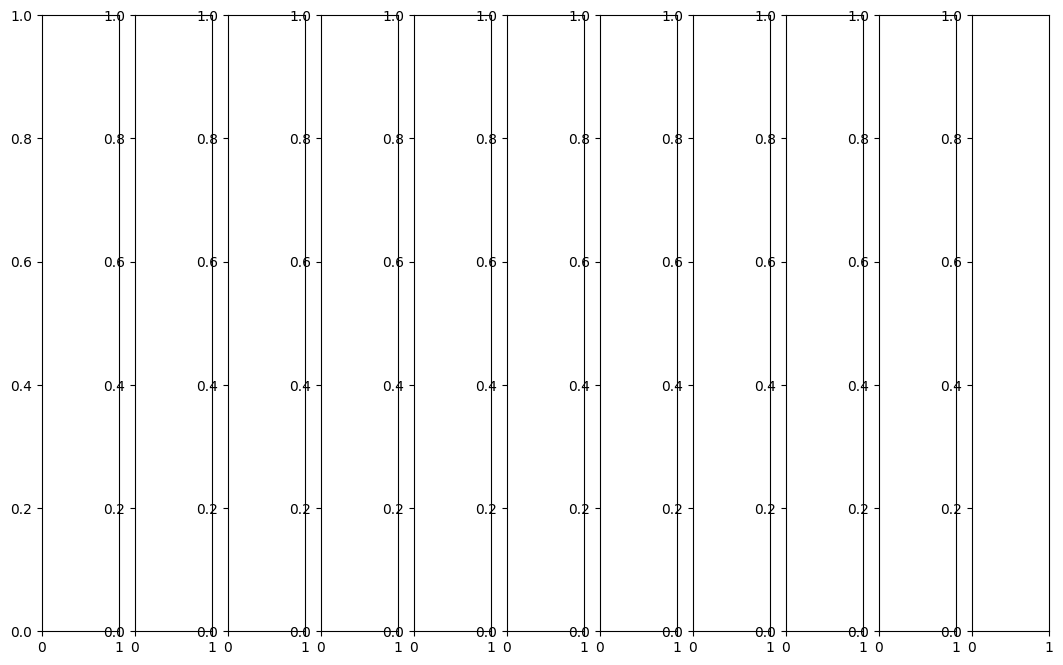

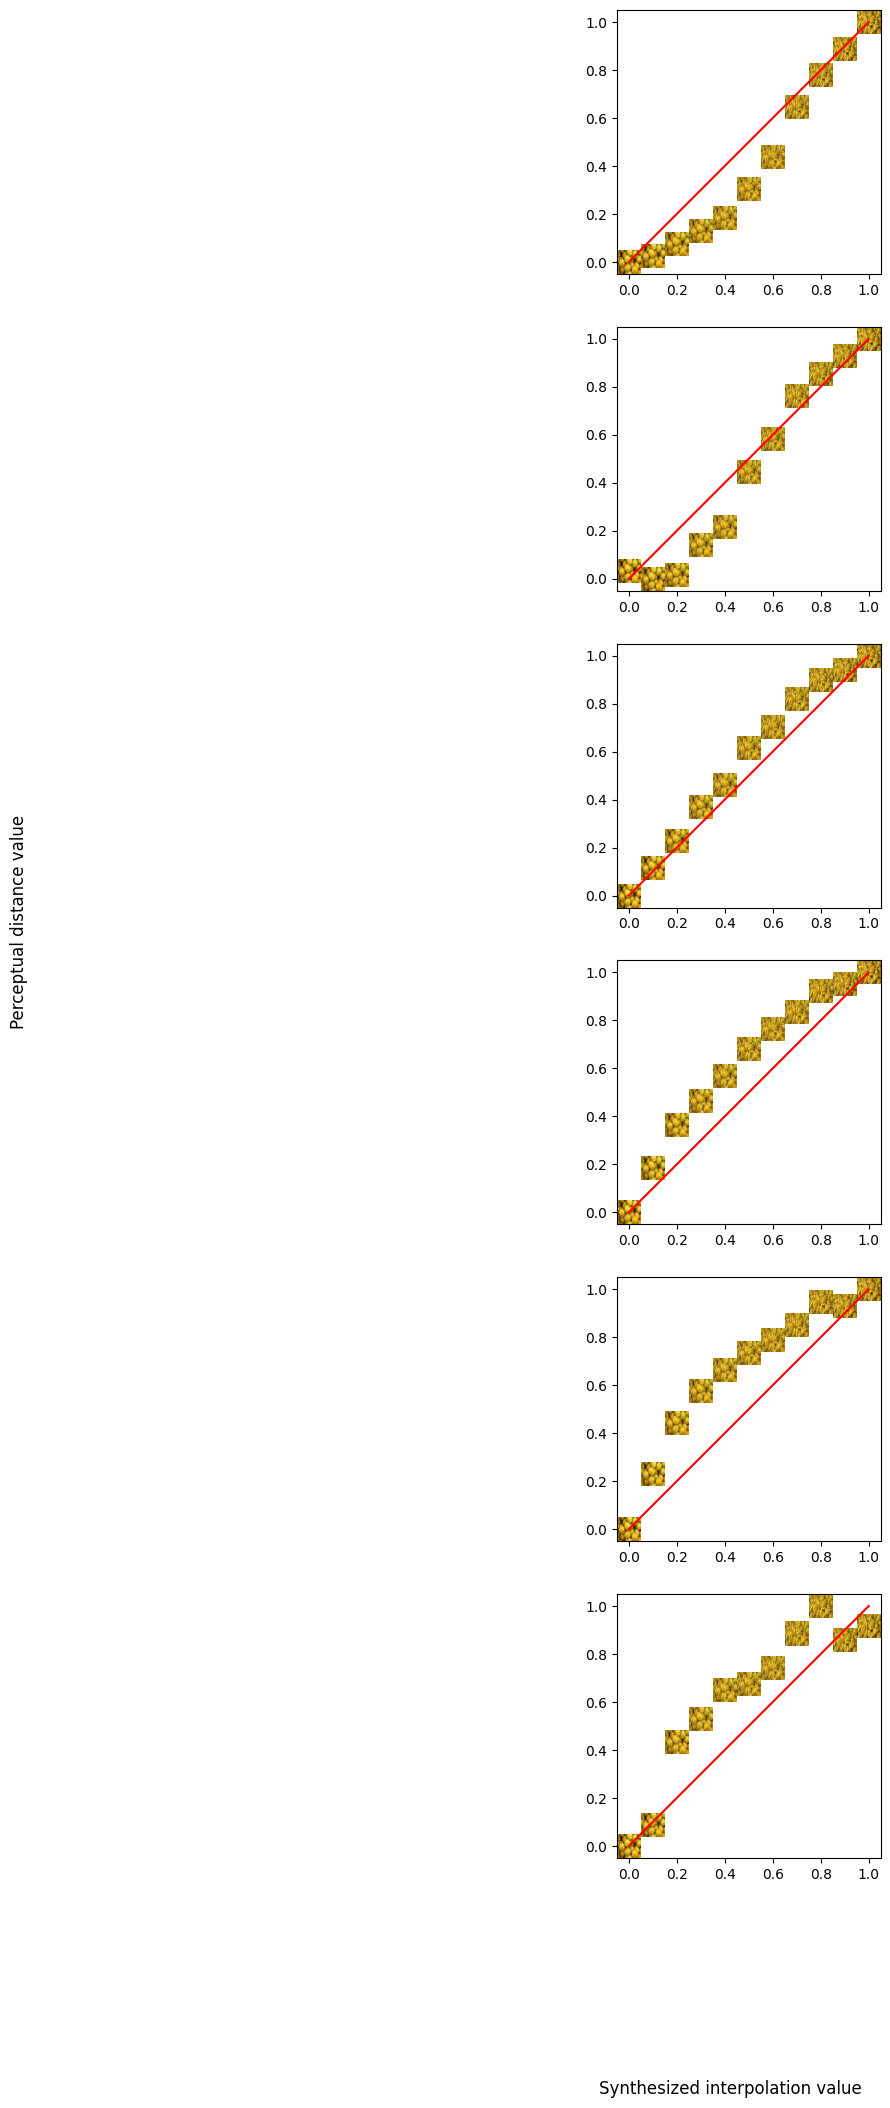

Optimization terminated successfully.
         Current function value: 371.234487
         Iterations: 914
         Function evaluations: 1278
Optimization terminated successfully.
         Current function value: 306.938586
         Iterations: 869
         Function evaluations: 1216
Optimization terminated successfully.
         Current function value: 213.320854
         Iterations: 744
         Function evaluations: 1044
Optimization terminated successfully.
         Current function value: 154.467649
         Iterations: 734
         Function evaluations: 1029
Optimization terminated successfully.
         Current function value: 105.547295
         Iterations: 658
         Function evaluations: 938
Optimization terminated successfully.
         Current function value: 131.718742
         Iterations: 928
         Function evaluations: 1299


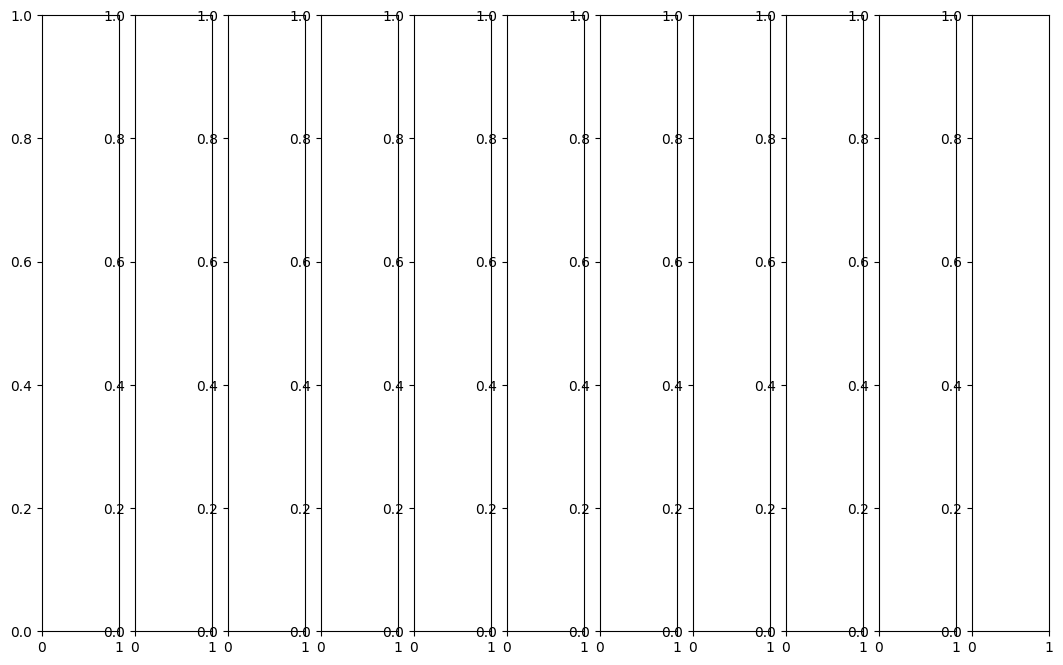

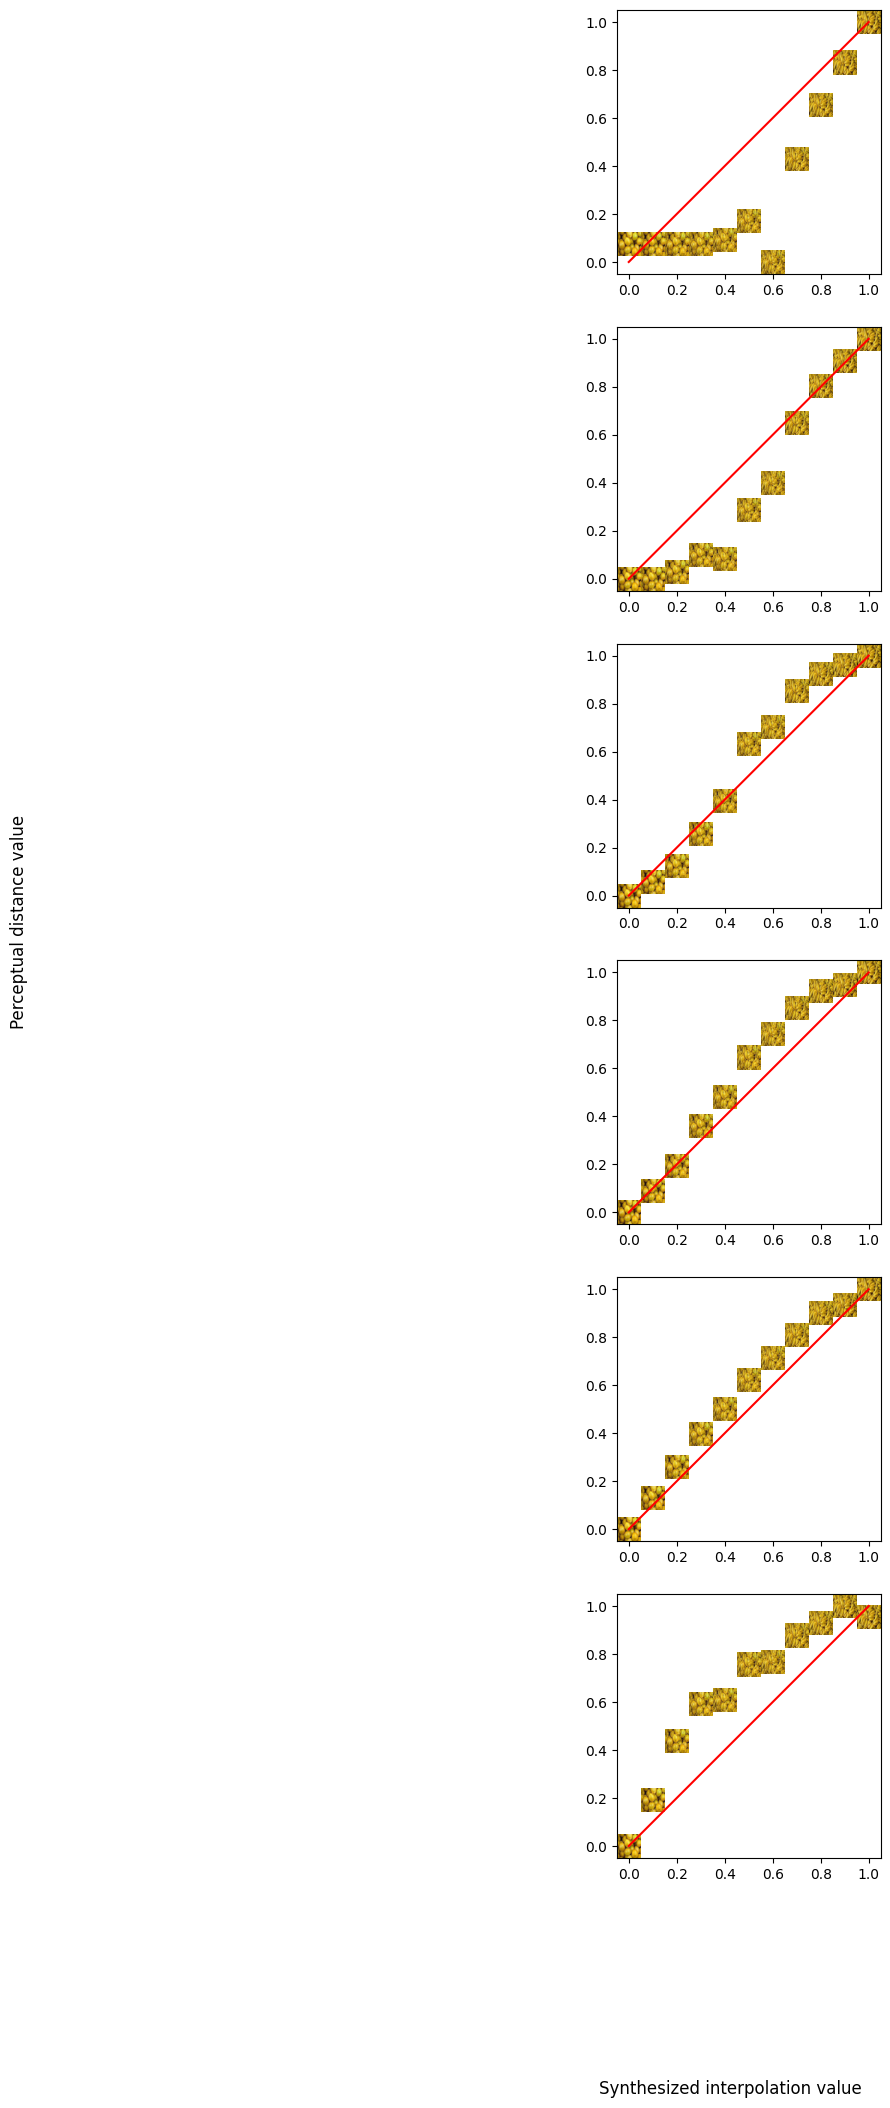

In [148]:
Psis = {};
mldsSigmas = {};

for model_name in model_names:
    saveFigures = 0
    activationLoss = 0
    fade = 0
    input_size = 224 if model_name != 'InceptionV3' else 299  # Set input size based on model
    
    # Load the model and initialize the activation hooks
    model, activations, layers_to_extract = get_model(model_name)
    
    # I am just setting the visualizaion layer to the last one.
    layer = len(layers_to_extract)-1 
    
    # Actually go through and extract all activations
    #image1Names = ['acorns', 'grass', 'lemons', 'pebbles', 'petals']
    #image2Names = ['redwood', 'leaves', 'bananas', 'granite', 'buttercream']
    
    image1Names = ['lemons']
    image2Names = ['bananas']
    
    interpValues = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    interpNames = [f"{string1}_{string2}" for string1, string2 in zip(image1Names, image2Names)]
    
    allActivations = {}; allImages = {}; imageNames = []; imageIndex = 0;
    
    for interpName in interpNames:
        for interpValue in interpValues:
            img_path = os.path.join('out', interpName, '10x10', 
                    f"{image1Names[imageIndex]}_{interpValue}_{image2Names[imageIndex]}_10x10_pool4_smp1.png")
            imageName = f"{interpName}_{interpValue}"
            # Different name if doing activation loss images
            if activationLoss == 1:
                img_path = 'out_activations_bal/' + image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_1x1' + '_pool4_smp1.png'
            if fade == 1:
                img_path = 'fades/' + image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_pool4_smp1.png'
            #print(img_path)
            x = preprocess_image(img_path, input_size)
            unprocessed_image = load_image(img_path, input_size)
            
            # Reset activations
            activations.clear()
    
            # Forward pass through the model
            with torch.no_grad():
                model(x)
    
            # Save outputs
            allActivations[imageName] = [activation.numpy() for activation in activations]
            allImages[imageName] = unprocessed_image.squeeze(0).permute(1, 2, 0).numpy()  # Save the original image
            imageNames.append(imageName)
    
        imageIndex += 1


    ## now do the mlds and 
    # pick which layers you want to look at
    #layers = [conv1, pool1, pool2, pool3, pool4, pool5, end]
    layers = range(0,len(layers_to_extract))
    
    # init a figure
    fig = plt.figure(figsize=(15, 4*len(layers)))
    sub = 0;

    #create empty dicts to store psi values for each model
    Psis[model_name] = {}
    mldsSigmas[model_name] = {}

    #iterate through layers, doing mlds
    for layer in layers:
    
        # iterate through interpolations
        for interpPair in range(len(interpNames)):
            
            # make an empty list to keep track
            biggerDiff = [];
    
            # simulate the 2AFC decisions based on cosine dissimilarity between embeddings
            for pairings in all_combinations.astype(int):
                # add which interp number this is by adding amount of pairs you've iterated * num interp values
                pairings = tuple(x + interpPair*len(interpValues) for x in pairings)
                # get the index from all activations to the pairs
                im1 = pairings[0]; im2 = pairings[1]; im3 = pairings[2]; im4 = pairings[3];
                # calcuate the distances
                dist12 = scipy.spatial.distance.cosine(allActivations[imageNames[im1]][layer].flatten(), allActivations[imageNames[im2]][layer].flatten())
                dist34 = scipy.spatial.distance.cosine(allActivations[imageNames[im3]][layer].flatten(), allActivations[imageNames[im4]][layer].flatten())
                if dist12 > dist34:
                    biggerDiff.append(1)
                elif dist34 > dist12:
                    biggerDiff.append(2)
                else:
                    biggerDiff.append(0)
            
            
            # set up initial params
            psi = np.arange(0, 11)/10 #np.random.rand(11)#
            sigma = 0.2
            initial_params = np.concatenate((psi, [sigma]))
            
            # search for params
            optimal_params = fmin(compute_loss, initial_params, args=(all_combinations, biggerDiff));
            psi = optimal_params[:11]
            psi = psi - np.min(psi)
            psi = psi / np.max(psi)
    
            # save the fit parameters (psi and sigma values)
            Psis[model_name][(layer, interpPair)] = psi;
            mldsSigmas[model_name][(layer, interpPair)] = optimal_params[11];
            
            # plot it
            plt.subplot(len(layers),len(image1Names),interpPair+1+sub*len(image1Names))
            
            # iterate over interp_values
            for interp_value in range(11):
                im = interpPair * len(interpValues) + interp_value
                plt.imshow(allImages[imageNames[im]], extent=[(interp_value ) / 10 - 0.05, (interp_value) / 10 + 0.05, psi[interp_value] - 0.05, psi[interp_value] + 0.05])
           
            # set axis limits
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.plot([0, 1], [0, 1], 'r')
    
        sub += 1        
    # show the plot
    fig.supylabel('Perceptual distance value')
    fig.supxlabel('Synthesized interpolation value')
    if saveFigures:
        plt.savefig('nn_mlds_figures/' + model_name + '.pdf')
    plt.show()
    
